In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import eval_GP_components
from bo_functions import calc_ei_total_test
from bo_functions import create_y_data

from bo_plotters import plot_hyperparams
from bo_plotters import sse_plotter
from bo_plotters import stdev_plotter
from bo_plotters import ei_plotter_adv_test
from bo_plotters import ei_plotter
from bo_plotters import plot_xy
from bo_plotters import error_plotter_4D
from bo_plotters import y_plotter_4D
from bo_plotters import stdev_plotter_4D

In [2]:
#Pull x and Y data from CSV
#Pull x data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]

n = len(Xexp)
q = 3
# print(n)
Theta_True = np.array([1,-1])

In [3]:
#Create training and test data
train_data_doc = "train_3_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
# print(train_data)
train_theta = train_data[:,1:3]
train_p = torch.tensor(train_data[:,1:4])
train_y = torch.tensor(train_data[:,4])
# print(train_p)
# print(train_y)

In [4]:
#Create Meshgrid
p = 10
Theta1 = np.linspace(-2,2,p)
Theta2 = np.linspace(-2,2,p)

theta_mesh = np.array(np.meshgrid(Theta1,Theta2))
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]

At Xexp =  -2.0 the GP mean is  [-8.70652646] and the GP variance is [0.54981077]
At Xexp =  -1.0 the GP mean is  [-5.49836897] and the GP variance is [0.49664058]
At Xexp =  0.0 the GP mean is  [-1.85863819] and the GP variance is [0.51923688]
At Xexp =  1.0 the GP mean is  [0.92234868] and the GP variance is [0.19520237]
At Xexp =  2.0 the GP mean is  [3.26915367] and the GP variance is [0.46910825]




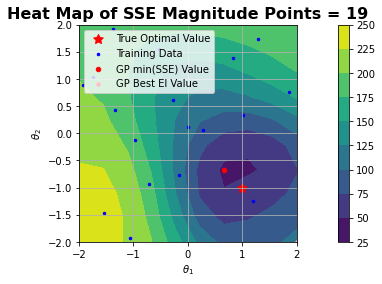

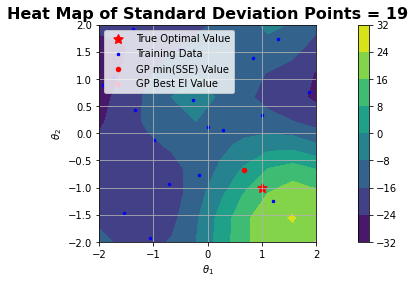

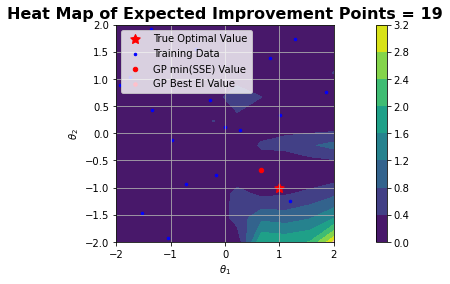

The GP estimates the highest EI is at Theta =  [ 2. -2.]  at iteration  0 

At Xexp =  -2.0 the GP mean is  [-13.88883797] and the GP variance is [0.5157408]
At Xexp =  -1.0 the GP mean is  [-5.46337523] and the GP variance is [0.60211349]
At Xexp =  0.0 the GP mean is  [-0.52095046] and the GP variance is [0.64000883]
At Xexp =  1.0 the GP mean is  [0.97111074] and the GP variance is [0.58632597]
At Xexp =  2.0 the GP mean is  [2.87785871] and the GP variance is [0.63754017]




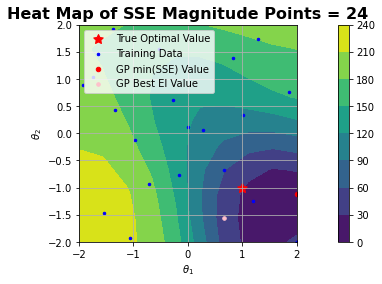

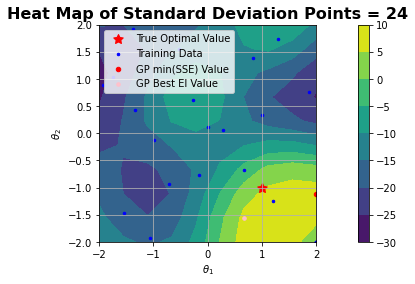

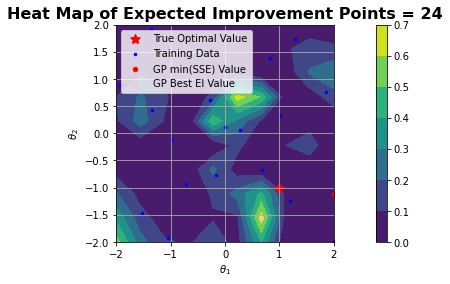

The GP estimates the highest EI is at Theta =  [ 0.66666667 -1.55555556]  at iteration  1 

At Xexp =  -2.0 the GP mean is  [-12.91501018] and the GP variance is [0.21223162]
At Xexp =  -1.0 the GP mean is  [-3.40118489] and the GP variance is [0.33768356]
At Xexp =  0.0 the GP mean is  [-0.12076597] and the GP variance is [0.38140535]
At Xexp =  1.0 the GP mean is  [0.70686304] and the GP variance is [0.27001935]
At Xexp =  2.0 the GP mean is  [3.77779082] and the GP variance is [0.36521078]




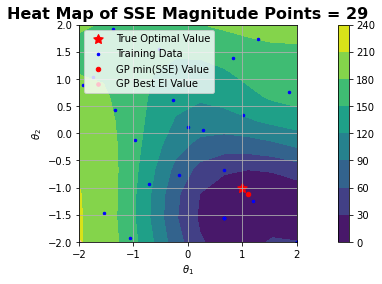

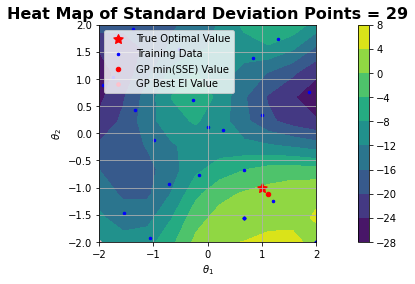

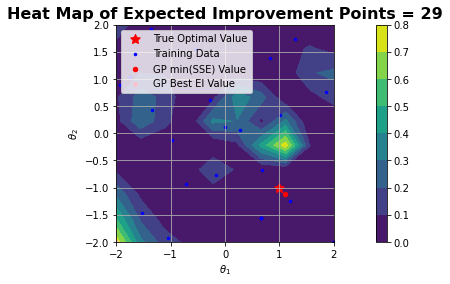

The GP estimates the highest EI is at Theta =  [-2. -2.]  at iteration  2 

At Xexp =  -2.0 the GP mean is  [-12.97869635] and the GP variance is [0.21222279]
At Xexp =  -1.0 the GP mean is  [-3.45494512] and the GP variance is [0.33743812]
At Xexp =  0.0 the GP mean is  [-0.20464063] and the GP variance is [0.38088779]
At Xexp =  1.0 the GP mean is  [0.70008753] and the GP variance is [0.26985306]
At Xexp =  2.0 the GP mean is  [3.71216626] and the GP variance is [0.36510114]




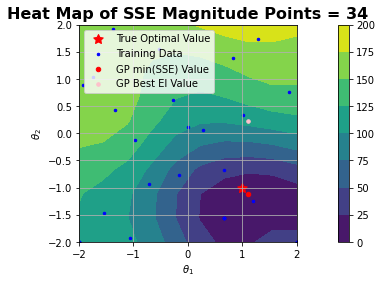

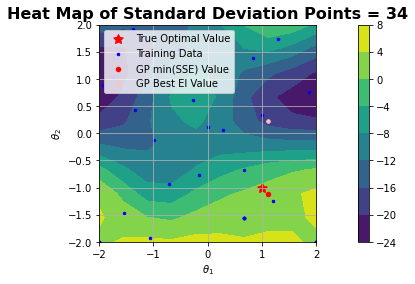

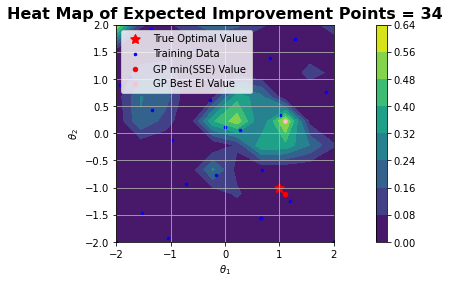

The GP estimates the highest EI is at Theta =  [1.11111111 0.22222222]  at iteration  3 

At Xexp =  -2.0 the GP mean is  [-13.72502766] and the GP variance is [0.19695364]
At Xexp =  -1.0 the GP mean is  [-3.12143358] and the GP variance is [0.29549197]
At Xexp =  0.0 the GP mean is  [0.13396488] and the GP variance is [0.34350693]
At Xexp =  1.0 the GP mean is  [0.75400666] and the GP variance is [0.26588345]
At Xexp =  2.0 the GP mean is  [5.13866267] and the GP variance is [0.33825254]




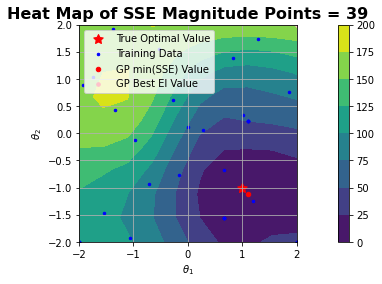

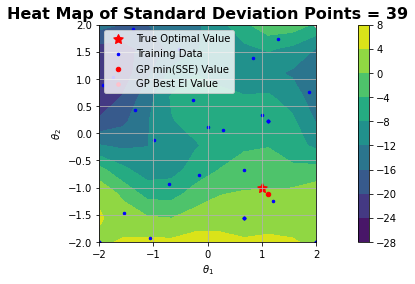

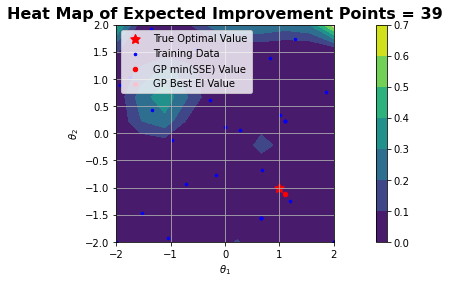

The GP estimates the highest EI is at Theta =  [2. 2.]  at iteration  4 

At Xexp =  -2.0 the GP mean is  [-13.67118418] and the GP variance is [0.19685589]
At Xexp =  -1.0 the GP mean is  [-3.1410402] and the GP variance is [0.29539002]
At Xexp =  0.0 the GP mean is  [0.30110648] and the GP variance is [0.34340859]
At Xexp =  1.0 the GP mean is  [0.74312003] and the GP variance is [0.26587963]
At Xexp =  2.0 the GP mean is  [4.80863614] and the GP variance is [0.33794994]




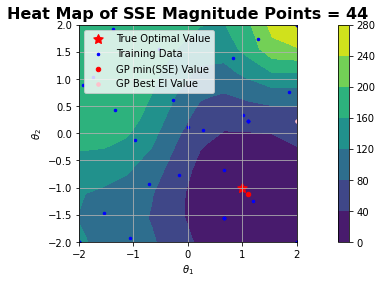

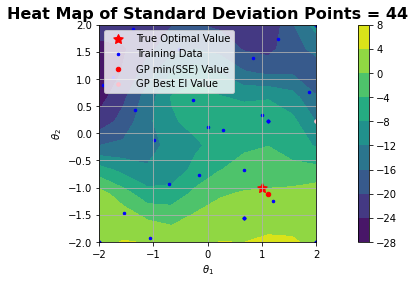

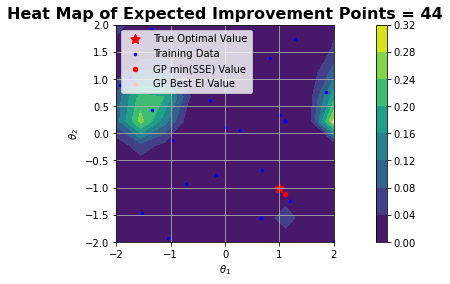

The GP estimates the highest EI is at Theta =  [2.         0.22222222]  at iteration  5 

At Xexp =  -2.0 the GP mean is  [-13.72224925] and the GP variance is [0.19671103]
At Xexp =  -1.0 the GP mean is  [-3.0196453] and the GP variance is [0.29424537]
At Xexp =  0.0 the GP mean is  [0.46504069] and the GP variance is [0.34079251]
At Xexp =  1.0 the GP mean is  [1.04618331] and the GP variance is [0.25914444]
At Xexp =  2.0 the GP mean is  [5.36229409] and the GP variance is [0.33146494]




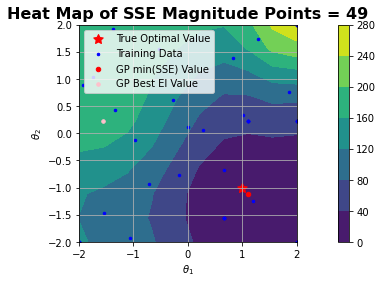

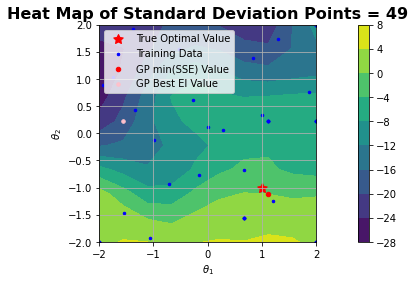

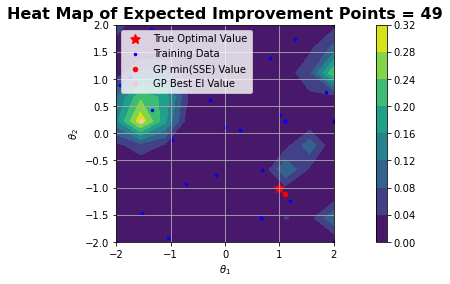

The GP estimates the highest EI is at Theta =  [-1.55555556  0.22222222]  at iteration  6 

At Xexp =  -2.0 the GP mean is  [-13.73092449] and the GP variance is [0.19670345]
At Xexp =  -1.0 the GP mean is  [-3.03744653] and the GP variance is [0.29419235]
At Xexp =  0.0 the GP mean is  [0.49201694] and the GP variance is [0.34062709]
At Xexp =  1.0 the GP mean is  [1.08990087] and the GP variance is [0.25821126]
At Xexp =  2.0 the GP mean is  [5.35800739] and the GP variance is [0.33087087]




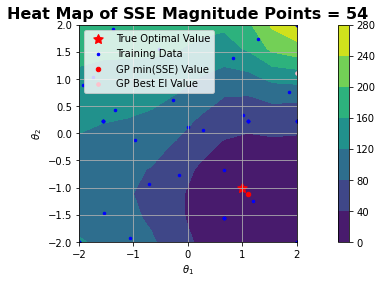

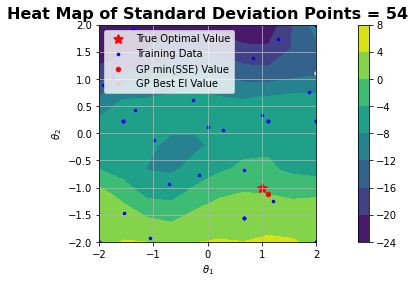

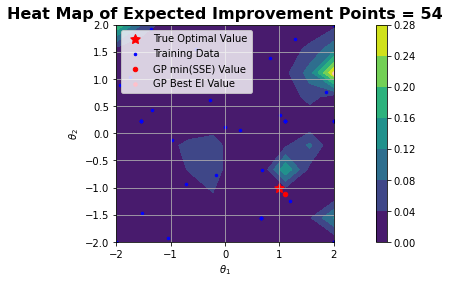

The GP estimates the highest EI is at Theta =  [2.         1.11111111]  at iteration  7 

At Xexp =  -2.0 the GP mean is  [-13.69959753] and the GP variance is [0.19495371]
At Xexp =  -1.0 the GP mean is  [-3.09767724] and the GP variance is [0.28895372]
At Xexp =  0.0 the GP mean is  [0.41788901] and the GP variance is [0.33394039]
At Xexp =  1.0 the GP mean is  [1.04248585] and the GP variance is [0.25739825]
At Xexp =  2.0 the GP mean is  [5.26218712] and the GP variance is [0.32627198]




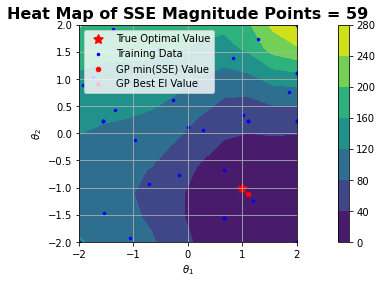

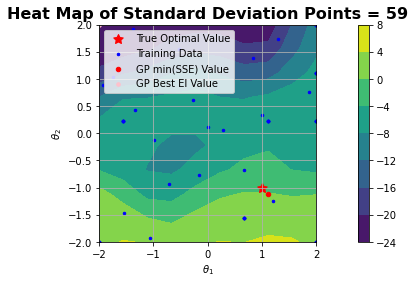

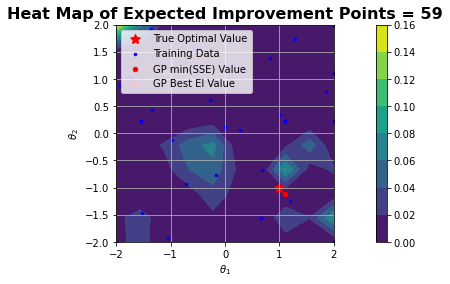

The GP estimates the highest EI is at Theta =  [-2.  2.]  at iteration  8 

At Xexp =  -2.0 the GP mean is  [-13.67611564] and the GP variance is [0.19495361]
At Xexp =  -1.0 the GP mean is  [-3.12917245] and the GP variance is [0.28895176]
At Xexp =  0.0 the GP mean is  [0.40918143] and the GP variance is [0.33393927]
At Xexp =  1.0 the GP mean is  [1.011445] and the GP variance is [0.25738658]
At Xexp =  2.0 the GP mean is  [5.24676401] and the GP variance is [0.32626462]




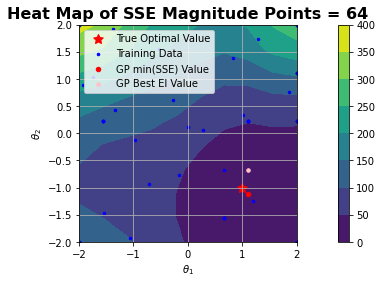

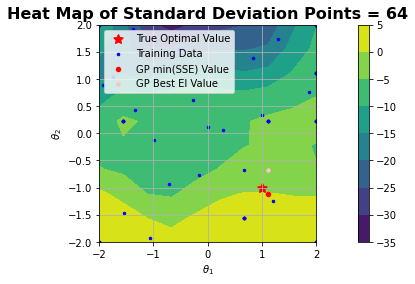

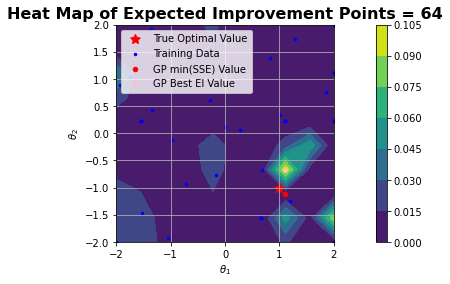

The GP estimates the highest EI is at Theta =  [ 1.11111111 -0.66666667]  at iteration  9 

At Xexp =  -2.0 the GP mean is  [-14.31221278] and the GP variance is [0.15171039]
At Xexp =  -1.0 the GP mean is  [-3.38362617] and the GP variance is [0.17564922]
At Xexp =  0.0 the GP mean is  [0.15552704] and the GP variance is [0.18320804]
At Xexp =  1.0 the GP mean is  [0.9369346] and the GP variance is [0.18001883]
At Xexp =  2.0 the GP mean is  [5.5490488] and the GP variance is [0.19063247]




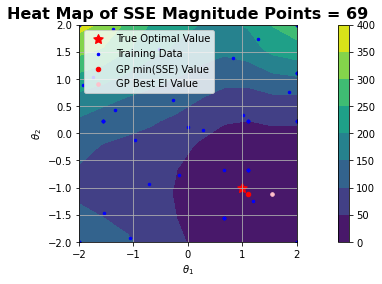

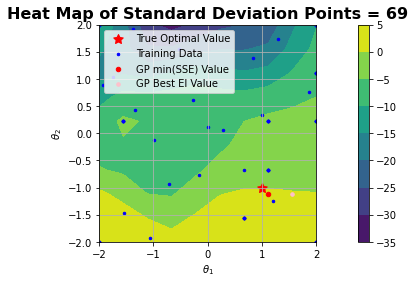

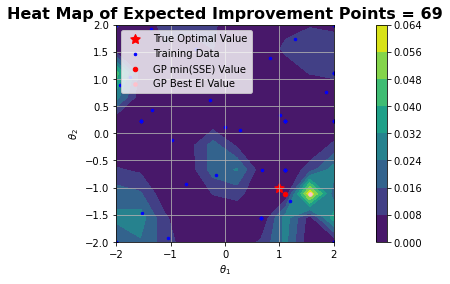

The GP estimates the highest EI is at Theta =  [ 1.55555556 -1.11111111]  at iteration  10 

At Xexp =  -2.0 the GP mean is  [-14.42322313] and the GP variance is [0.13988843]
At Xexp =  -1.0 the GP mean is  [-3.34559101] and the GP variance is [0.14924265]
At Xexp =  0.0 the GP mean is  [0.06579518] and the GP variance is [0.15089454]
At Xexp =  1.0 the GP mean is  [0.91307716] and the GP variance is [0.14488774]
At Xexp =  2.0 the GP mean is  [5.68116089] and the GP variance is [0.15424462]




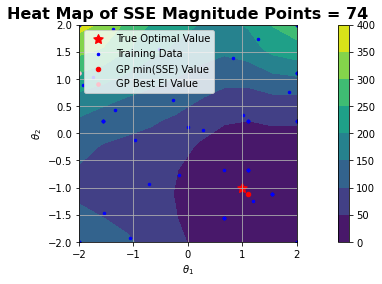

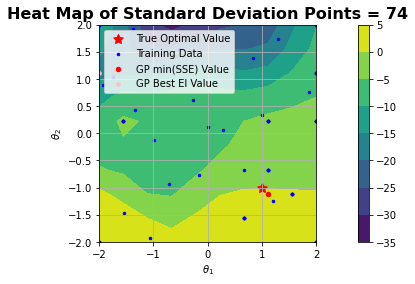

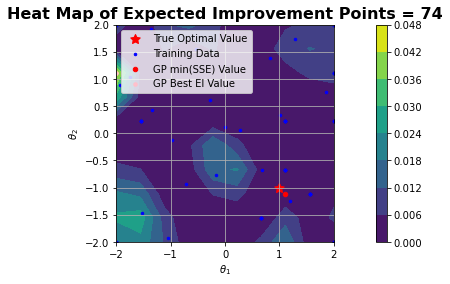

The GP estimates the highest EI is at Theta =  [-2.          1.11111111]  at iteration  11 

At Xexp =  -2.0 the GP mean is  [-14.42350759] and the GP variance is [0.13988837]
At Xexp =  -1.0 the GP mean is  [-3.34703548] and the GP variance is [0.14924157]
At Xexp =  0.0 the GP mean is  [0.06451293] and the GP variance is [0.15089431]
At Xexp =  1.0 the GP mean is  [0.90880141] and the GP variance is [0.14488607]
At Xexp =  2.0 the GP mean is  [5.67882269] and the GP variance is [0.15424354]




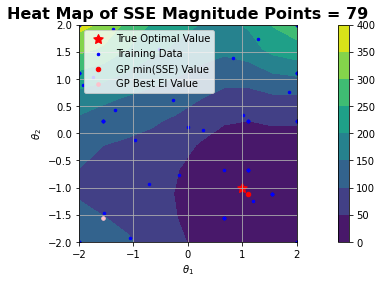

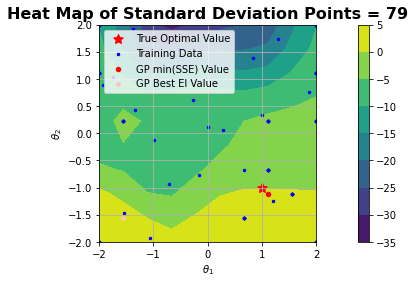

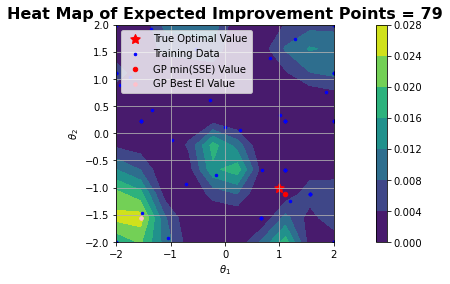

The GP estimates the highest EI is at Theta =  [-1.55555556 -1.55555556]  at iteration  12 

At Xexp =  -2.0 the GP mean is  [-14.41320493] and the GP variance is [0.13984225]
At Xexp =  -1.0 the GP mean is  [-3.34868228] and the GP variance is [0.14915338]
At Xexp =  0.0 the GP mean is  [0.064687] and the GP variance is [0.15086088]
At Xexp =  1.0 the GP mean is  [0.91898523] and the GP variance is [0.14484586]
At Xexp =  2.0 the GP mean is  [5.67441204] and the GP variance is [0.15422913]




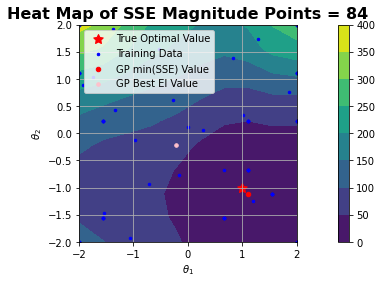

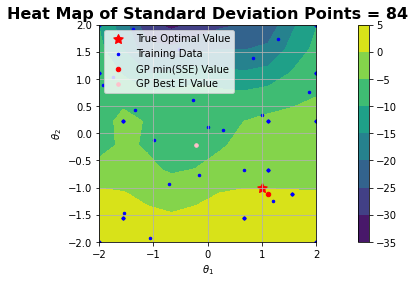

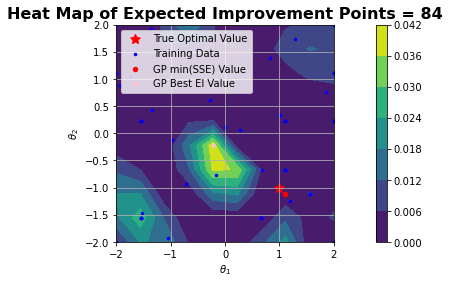

The GP estimates the highest EI is at Theta =  [-0.22222222 -0.22222222]  at iteration  13 

At Xexp =  -2.0 the GP mean is  [-14.44833311] and the GP variance is [0.13973128]
At Xexp =  -1.0 the GP mean is  [-3.33921657] and the GP variance is [0.14907538]
At Xexp =  0.0 the GP mean is  [0.07522813] and the GP variance is [0.15075866]
At Xexp =  1.0 the GP mean is  [0.91354108] and the GP variance is [0.1447499]
At Xexp =  2.0 the GP mean is  [5.70011513] and the GP variance is [0.15416845]




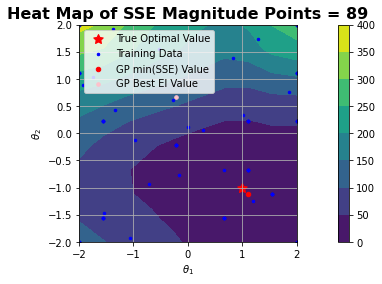

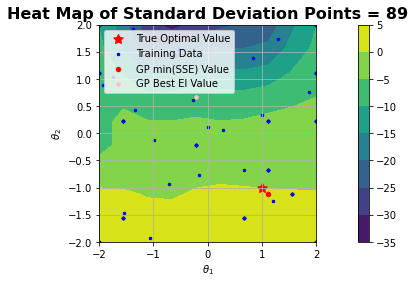

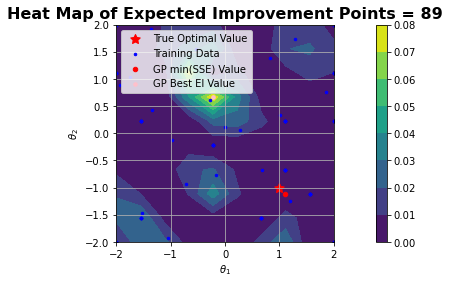

The GP estimates the highest EI is at Theta =  [-0.22222222  0.66666667]  at iteration  14 

At Xexp =  -2.0 the GP mean is  [-14.43726823] and the GP variance is [0.13971164]
At Xexp =  -1.0 the GP mean is  [-3.35642755] and the GP variance is [0.14904384]
At Xexp =  0.0 the GP mean is  [0.08461073] and the GP variance is [0.15073653]
At Xexp =  1.0 the GP mean is  [0.9613968] and the GP variance is [0.14460236]
At Xexp =  2.0 the GP mean is  [5.65682515] and the GP variance is [0.15410559]




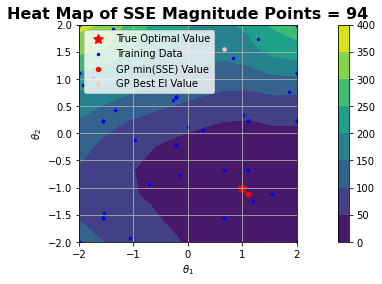

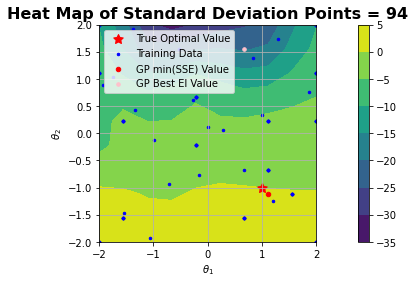

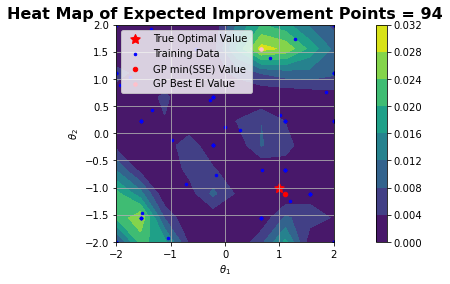

The GP estimates the highest EI is at Theta =  [0.66666667 1.55555556]  at iteration  15 

At Xexp =  -2.0 the GP mean is  [-14.43782008] and the GP variance is [0.13970832]
At Xexp =  -1.0 the GP mean is  [-3.36146634] and the GP variance is [0.14903538]
At Xexp =  0.0 the GP mean is  [0.08156964] and the GP variance is [0.15072678]
At Xexp =  1.0 the GP mean is  [0.97252004] and the GP variance is [0.14459053]
At Xexp =  2.0 the GP mean is  [5.65669053] and the GP variance is [0.1540955]




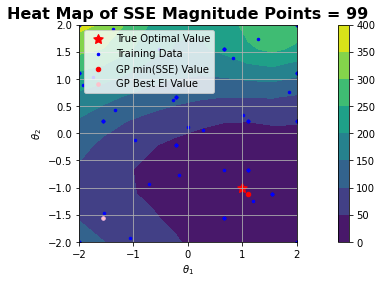

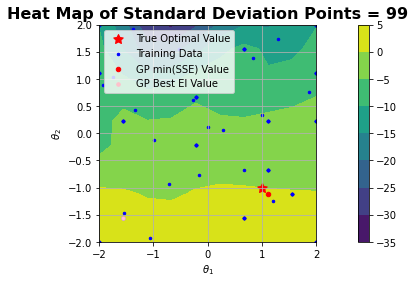

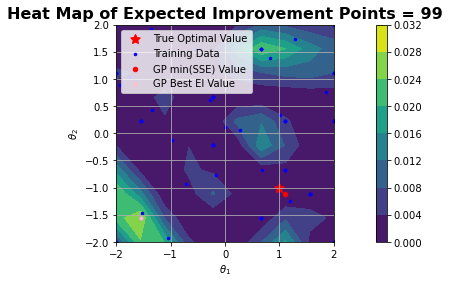

The GP estimates the highest EI is at Theta =  [-1.55555556 -1.55555556]  at iteration  16 

At Xexp =  -2.0 the GP mean is  [-14.43564754] and the GP variance is [0.13970041]
At Xexp =  -1.0 the GP mean is  [-3.36431263] and the GP variance is [0.14902147]
At Xexp =  0.0 the GP mean is  [0.08050241] and the GP variance is [0.15071908]
At Xexp =  1.0 the GP mean is  [0.97405313] and the GP variance is [0.14458478]
At Xexp =  2.0 the GP mean is  [5.6558278] and the GP variance is [0.15408915]




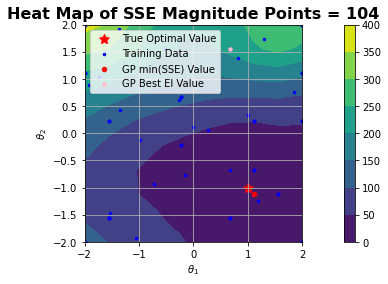

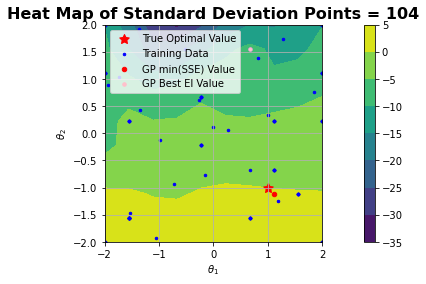

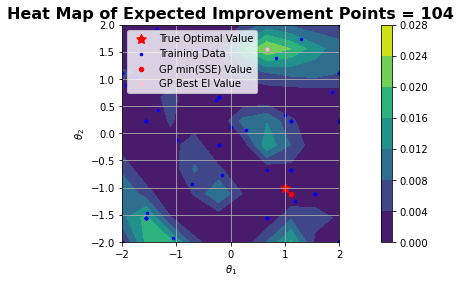

The GP estimates the highest EI is at Theta =  [0.66666667 1.55555556]  at iteration  17 

At Xexp =  -2.0 the GP mean is  [-14.43605134] and the GP variance is [0.13969947]
At Xexp =  -1.0 the GP mean is  [-3.36175639] and the GP variance is [0.1490198]
At Xexp =  0.0 the GP mean is  [0.07951342] and the GP variance is [0.15071712]
At Xexp =  1.0 the GP mean is  [0.97738962] and the GP variance is [0.14458376]
At Xexp =  2.0 the GP mean is  [5.65554824] and the GP variance is [0.1540879]




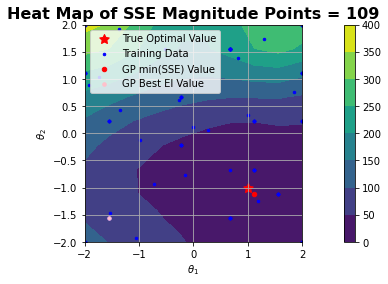

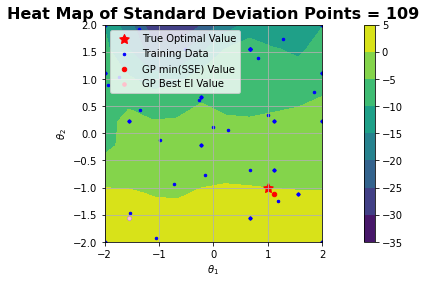

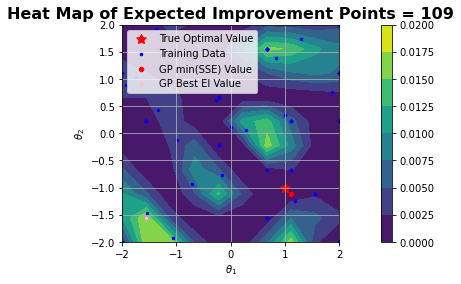

The GP estimates the highest EI is at Theta =  [-1.55555556 -1.55555556]  at iteration  18 

At Xexp =  -2.0 the GP mean is  [-14.43495917] and the GP variance is [0.1396963]
At Xexp =  -1.0 the GP mean is  [-3.36121785] and the GP variance is [0.14901358]
At Xexp =  0.0 the GP mean is  [0.07973517] and the GP variance is [0.15071335]
At Xexp =  1.0 the GP mean is  [0.98022769] and the GP variance is [0.14458101]
At Xexp =  2.0 the GP mean is  [5.656576] and the GP variance is [0.15408471]




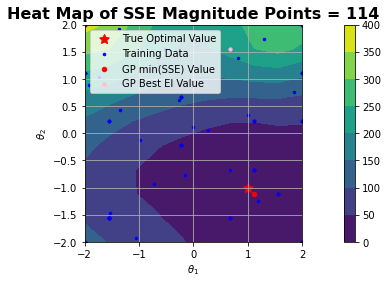

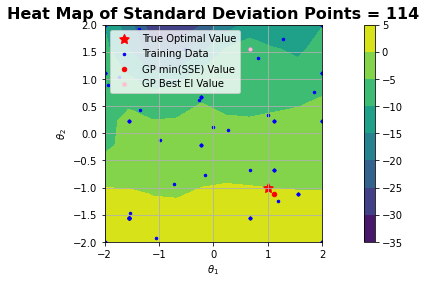

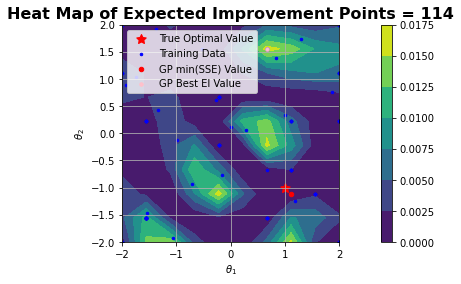

The GP estimates the highest EI is at Theta =  [0.66666667 1.55555556]  at iteration  19 

At Xexp =  -2.0 the GP mean is  [-14.43532454] and the GP variance is [0.13969583]
At Xexp =  -1.0 the GP mean is  [-3.36049777] and the GP variance is [0.14901278]
At Xexp =  0.0 the GP mean is  [0.07878743] and the GP variance is [0.1507124]
At Xexp =  1.0 the GP mean is  [0.98098913] and the GP variance is [0.14458059]
At Xexp =  2.0 the GP mean is  [5.65586327] and the GP variance is [0.15408415]




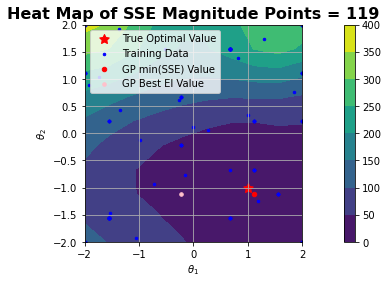

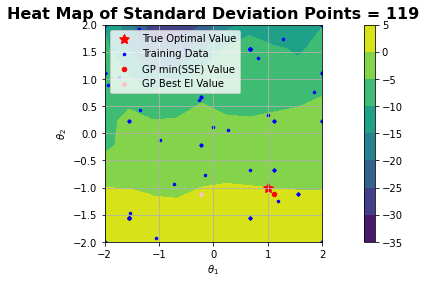

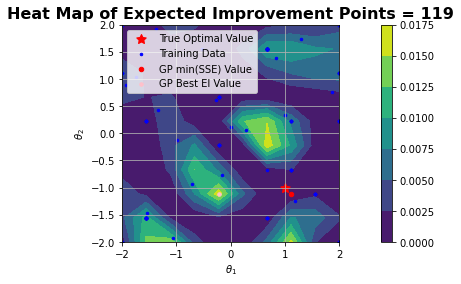

The GP estimates the highest EI is at Theta =  [-0.22222222 -1.11111111]  at iteration  20 

At Xexp =  -2.0 the GP mean is  [-14.45829624] and the GP variance is [0.13960593]
At Xexp =  -1.0 the GP mean is  [-3.33892923] and the GP variance is [0.14855693]
At Xexp =  0.0 the GP mean is  [0.05040664] and the GP variance is [0.15030278]
At Xexp =  1.0 the GP mean is  [0.94707873] and the GP variance is [0.14407537]
At Xexp =  2.0 the GP mean is  [5.644878] and the GP variance is [0.15384918]




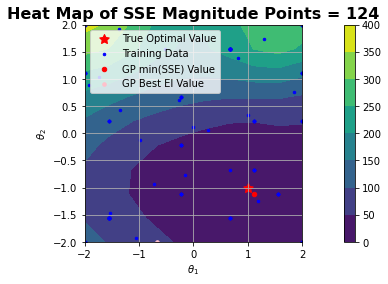

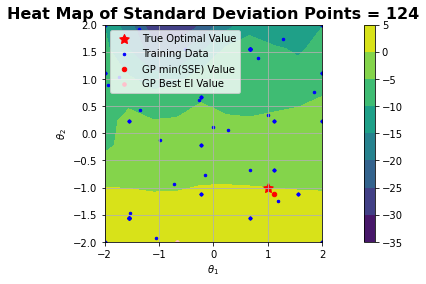

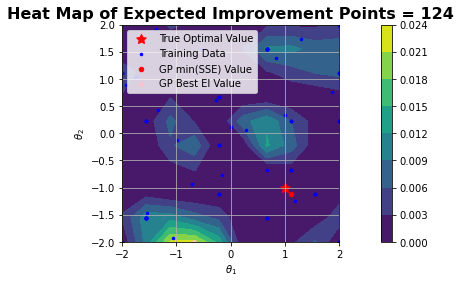

The GP estimates the highest EI is at Theta =  [-0.66666667 -2.        ]  at iteration  21 

At Xexp =  -2.0 the GP mean is  [-14.29289886] and the GP variance is [0.13888437]
At Xexp =  -1.0 the GP mean is  [-3.28045033] and the GP variance is [0.14748849]
At Xexp =  0.0 the GP mean is  [0.04913259] and the GP variance is [0.14933966]
At Xexp =  1.0 the GP mean is  [0.98240097] and the GP variance is [0.14342812]
At Xexp =  2.0 the GP mean is  [5.70233063] and the GP variance is [0.15258983]




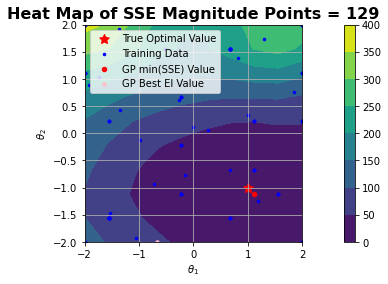

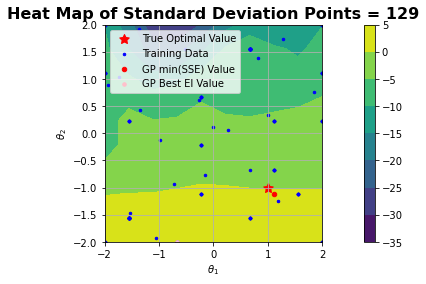

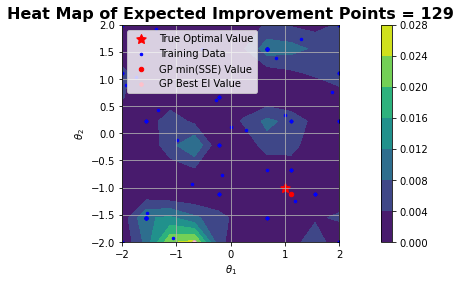

The GP estimates the highest EI is at Theta =  [-0.66666667 -2.        ]  at iteration  22 

At Xexp =  -2.0 the GP mean is  [-14.27342636] and the GP variance is [0.13881328]
At Xexp =  -1.0 the GP mean is  [-3.28368557] and the GP variance is [0.14738899]
At Xexp =  0.0 the GP mean is  [0.04685906] and the GP variance is [0.14918516]
At Xexp =  1.0 the GP mean is  [0.9889281] and the GP variance is [0.14333436]
At Xexp =  2.0 the GP mean is  [5.70689655] and the GP variance is [0.15246849]




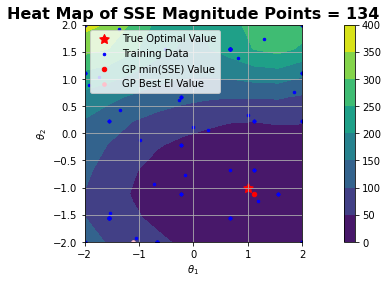

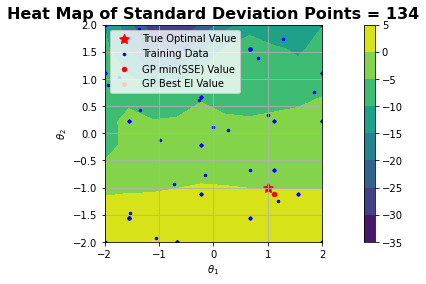

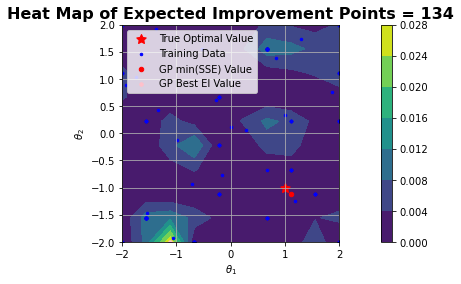

The GP estimates the highest EI is at Theta =  [-1.11111111 -2.        ]  at iteration  23 

At Xexp =  -2.0 the GP mean is  [-14.27521757] and the GP variance is [0.13870433]
At Xexp =  -1.0 the GP mean is  [-3.2869841] and the GP variance is [0.14717126]
At Xexp =  0.0 the GP mean is  [0.04746981] and the GP variance is [0.14895749]
At Xexp =  1.0 the GP mean is  [0.98673337] and the GP variance is [0.14317082]
At Xexp =  2.0 the GP mean is  [5.70525988] and the GP variance is [0.15228192]




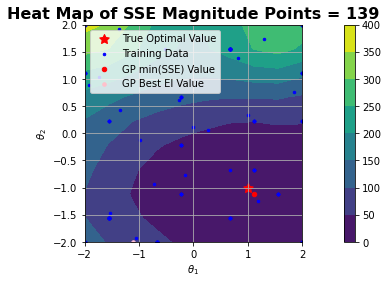

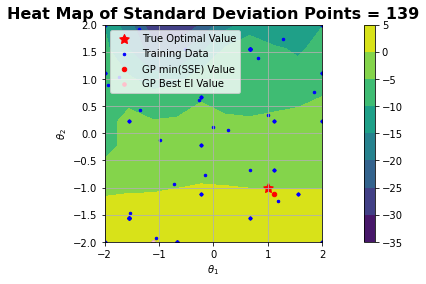

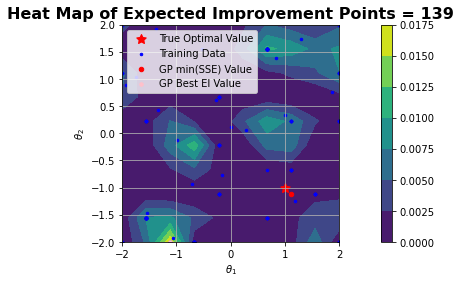

The GP estimates the highest EI is at Theta =  [-1.11111111 -2.        ]  at iteration  24 



In [5]:
#Set number of training iterations and train GP
iterations = 500
BO_iters = 25
for i in range(BO_iters):
    if torch.is_tensor(train_p) != True:
        train_p = torch.from_numpy(train_p)
    if torch.is_tensor(train_y) != True:
        train_y = torch.from_numpy(train_y)
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_p, train_y, likelihood)
    
    train_GP = train_GP_model(model,likelihood, train_p, train_y, iterations, verbose=False)
    noise_list = train_GP[0]
    lengthscale_list = train_GP[1]
    outputscale_list = train_GP[2]
    
#     #Plot hyperparameters vs iteration
#     noise_title = "Noise Hyperparameter"
#     lengthscale_title = "Lengthscale Hyperparameter"
#     outputscale_title = "Outputscale Hyperparameter"
#     plot_hyperparams(iterations, noise_list,noise_title)
#     plot_hyperparams(iterations, lengthscale_list,lengthscale_title)
#     plot_hyperparams(iterations, outputscale_list,outputscale_title)
    
    outputscale = torch.tensor([1])
    lengthscale = torch.tensor([1])
    noise = torch.tensor([0.1])

    model.likelihood.noise = noise
    model.covar_module.base_kernel.lengthscale =lengthscale
    model.covar_module.outputscale = outputscale
    
#     print("Noise Hyperparameter: ", float(model.likelihood.noise))
#     print("Lengthscale Hyperparameter: ", float(model.covar_module.base_kernel.lengthscale))
#     print("Outputscale Hyperparameter: ", float(model.covar_module.outputscale))
    
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval();
    
    #Will compare the rigorous solution and approximation later (multidimensional integral over each experiment using a sparse grid)
    #Calculate EI
    EI_Components = eval_GP_components(p,n,Xexp,Yexp, theta_mesh, model, likelihood)
    EI = EI_Components[0]
    SSE =EI_Components[1]
    y_GP = EI_Components[2]
    stdev_GP = EI_Components[3]
    error_GP = EI_Components[4]
    SSE_var_GP = EI_Components[5]
#     print(Error)

    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    argmin = np.array(np.where(np.isclose(SSE, np.amin(SSE),atol=1e-10)==True))
    Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
    Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
    Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))


    #calculates best theta value
    argmax = np.array(np.where(np.isclose(EI, np.amax(EI),atol=1e-10)==True))
    #     print(argmax)
    Theta1_Best = float(theta1_mesh[argmax[0],argmax[1]])
    Theta2_Best = float(theta2_mesh[argmax[0],argmax[1]])
    Theta_Best = np.array((Theta1_Best,Theta2_Best))
    
    
#     If statement to show convergence
#     Converge = np.allclose(Theta_Best, train_p[-1,0:2],atol=1e-10)
#     if Converge == True or i ==BO_iters-1:
#         sse_plotter(theta_mesh, SSE, Theta_True, Theta_Opt_GP, Theta_Best,train_p,plot_train=True)
#         stdev_plotter(theta_mesh, SSE_var_GP, Theta_True, Theta_Opt_GP, Theta_Best, train_p,plot_train=True)
#         ei_plotter(theta_mesh, EI, Theta_True, Theta_Opt_GP,Theta_Best,train_p,plot_train=True)
#         print("Final number of iterations: ", i+1)
#         print("The SSE at the GP mean is lowest at Theta =",Theta_Opt_GP)
#         print("The GP estimates the highest EI is at Theta = ",Theta_Best)
        
#         for j in range(n):
#             x = Xexp[j]
#             GP_mean = y_GP[argmin[0],argmin[1],j]
#             GP_var = (stdev_GP[argmin[0],argmin[1],j])**2
#             print("At Xexp = ",x,"the GP mean is ", GP_mean, "and the GP variance is", GP_var)
#         break
    
    for j in range(n):
        x = Xexp[j]
        GP_mean = y_GP[argmin[0],argmin[1],j]
        GP_var = (stdev_GP[argmin[0],argmin[1],j])**2
        print("At Xexp = ",x,"the GP mean is ", GP_mean, "and the GP variance is", GP_var)
    print("\n")
        
    sse_plotter(theta_mesh, SSE, Theta_True, Theta_Opt_GP, Theta_Best,train_p,plot_train=True)
    stdev_plotter(theta_mesh, SSE_var_GP, Theta_True, Theta_Opt_GP, Theta_Best, train_p,plot_train=True)
    ei_plotter(theta_mesh, EI, Theta_True, Theta_Opt_GP, Theta_Best,train_p,plot_train=True)
#     print("The SSE at the GP mean is lowest at Theta =",Theta_Opt_GP, " at iteration ", i+1)
    print("The GP estimates the highest EI is at Theta = ",Theta_Best, " at iteration ", i+1, "\n")

    ##Append best values to training data 
    #Convert training data to numpy arrays to allow concatenation to work
    train_p = train_p.numpy() #(q x t)
    train_y = train_y.numpy() #(1 x t)
    
    #Loops over Xexp values
    for j in range(n):
#         print(train_y)
        ##Calculate y_Best and formal p_Best
        #Add 5 test points, same Theta1 and Theta2, but use all values of Xexp
        p_Best = np.array([Theta_Best[0],Theta_Best[1],Xexp[j]]) #(q x 1)
#         print(p_Best)
        y_Best = create_y_data(q,p_Best) #(1 x 1)
        
        #Add Theta_Best to train_p and y_best to train_y
        train_p = np.concatenate((train_p, [p_Best]), axis=0) #(q x t)
        train_y = np.concatenate((train_y, [y_Best]),axis=0) #(1 x t)




In [6]:
# EI_sing = calc_ei_total_test(p,n,Xexp,Yexp, theta_mesh, model, likelihood)[0]
# Error =calc_ei_total_test(p,n,Xexp,Yexp, theta_mesh, model, likelihood)[1]
# for i in range(n):    
#     ei_plotter_adv_test(theta_mesh, EI_sing[i], Theta_True, train_p,Xexp[i],Theta_Opt_GP,plot_train=True)

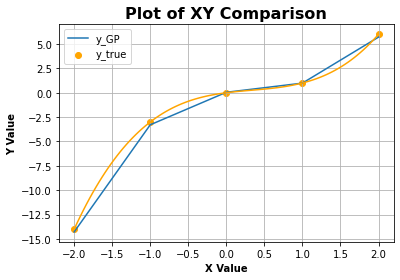

In [7]:
#Plot xy data
title = "XY Comparison"
y_GP_Opt = y_GP[argmin[0],argmin[1],:][0]
plot_xy(Xexp, Yexp, y_GP_Opt,Theta_True,title)

In [8]:
mesh_3D = np.meshgrid(Theta1,Theta2,Xexp)

In [ ]:
stdev_plot = stdev_plotter_4D(mesh_3D,stdev_GP)
print("Max Stdev: ", np.amax(stdev_GP))
print("Min Stdev: ", np.amin(stdev_GP))

## Analysis of Standard Deviation
 - The GP estimates that the standard deviation is lowest at points that were directly tested
  - This can be rationalized by the way that the contour plot is drawn
 - Standard deviation is smallest away from the edges and larger towards them
  - This is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The more points that get tested, the more the standard deviations will decrease

In [ ]:
error_plot = error_plotter_4D(mesh_3D,error_sq_GP)
print("Max Error: ", np.amax(error_GP))
print("Min Error: ", np.amin(error_GP))

## Analysis of Error Squared Magnitude
 - The GP emulator is most inaccurate when all values of $\bar{p}$ are at their extreme points 
  - In general, the GP is less accurate at extreme points, this is rationalized by the fact that there are less neighbors that the GP is tested and trained with at the boundaries
 - The GP emulator is most accurate after convergence
 - GP error is mostly very low, as more iterations are added, error decreases

In [ ]:
y_plot = y_plotter_4D(mesh_3D,y_GP)
print("Max y: ", np.amax(y_GP))
print("Min y: ", np.amin(y_GP))

## Analysis of GP Emulator (Model y)
 - The GP emulator correctly captures that y increases as $\bar{p}$ increases. This tells us that this GP emulator model could be viable
  - The GP emulator suitably estimates where the lowest y is achieved and the actual value of y
  - Slight error leads to small inaccuracies in the value of $\bar{\theta}$ and the values of y